# Predicting the Outcome of a Chess Match

Chess is a game that is simple to play, grab different pieces and use their corresponding movesets to defeat your opponent. Each piece has a specific move associated with it (eg. pawns only move directly forward, but only attack diagonally) the full move list can be seen in this link: https://www.ichess.net/blog/chess-pieces-moves/.  While the fundamentals of the game are quite simple, mastery of the game is a long road that only few have achieved. Chess is a game of perfect information meaning that every move executed is seen by both players and every move that is available afterwards each succesive move is known by both players. While this is true and all the information that comes with it is knows to both players, the perfect game of chess is still eluding professionals and artificial intellignece to this day. This is likely due to the immense number of moves that open up after any one move, with one move being either white making a move, or black making a move. To represent this better, after each player has made 5 moves each, the number of potential games climbs to around 70 trillion different variations.  This does include illegal moves such as both kings being put in check and moves that would obviously not be made such as putting yourself in a losing position but it still expresses the consequence each move has on the game as a whole. This can be seen in the following link: https://en.wikipedia.org/wiki/Shannon_number#:~:text=The%20Shannon%20number%2C%20named%20after,Black%2C%20and%20a%20typical%20game.  While I don't intend to solve for the perfect game of chess, as this is an incredibly difficult process, I hope to give some insight into certain strengths that different styles have and how different factors apply to the game and how to potentially predict any sort of outcome. 

To achieve this goal I will be using a training set and a test set from the dataset I found on kaggle at https://www.kaggle.com/datasnaek/chess to try and predict the outcome of the game.  The training set will consist of about 75% of the data from here, the testing set will be based on the other 25%.  The factors I hope to see would be win rates based on what colour piece you start with, what opening sequence is used (simplified), the skill ratings of each player, the number of moves in the game (depth of the game) and how this affects the outcome and any other factors that arise while going through this dataset. 

A couple of functions used are taken from what we used in class and changed to suit the needs of my models. The dataset was manipulated manually to allow the functions to work on it directly and return meaningful outputs.

For the dataframes used and created in this project, it is important to note that while I label everything as wins for either black or white this data can be interpreted with the following: White wins are black loses and black wins are white loses.

The project, along with the csv dataset file, can be found on my github page at https://github.com/drew4491/323_final_proj/tree/main 



In [142]:
! pip install qeds fiona geopandas xgboost gensim folium pyLDAvis descartes
import matplotlib.colors as mplc
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import pandas as pd
import qeds
import numpy as np
import seaborn as sns
%matplotlib inline

#changing default figure sizes
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 10
fig_size[1] = 8
plt.rcParams["figure.figsize"] = fig_size
# activate plot theme
import qeds
qeds.themes.mpl_style();
plotly_template = qeds.themes.plotly_template()
colors = qeds.themes.COLOR_CYCLE

# We will import all these here to ensure that they are loaded, but
# will usually re-import close to where they are used to make clear
# where the functions come from
from sklearn import (
    linear_model, metrics, neural_network, pipeline, model_selection, preprocessing
)

### Loading in the data set

In [143]:
#The games file is loaded on my github page and can be laoded into a project from this url. 
# The games file can also be downloaded from there, either way works

url = 'https://raw.githubusercontent.com/drew4491/323_final_proj/main/games.csv'
chess_raw = pd.read_csv(url)
#chess_raw = pd.read_csv("games.csv")
chess_raw.head()

,id,rated,created_at,last_move_at,turns,victory_status,winner,increment_code,white_id,white_rating,black_id,black_rating,moves,opening_eco,opening_name,opening_ply
0,TZJHLljE,False,1.504210e+12,1.504210e+12,13,outoftime,white,15+2,bourgris,1500,a-00,1191,d4 d5 c4 c6 cxd5 e6 dxe6 fxe6 Nf3 Bb4+ Nc3 Ba5...,D10,Slav Defense: Exchange Variation,5
1,l1NXvwaE,True,1.504130e+12,1.504130e+12,16,resign,black,5+10,a-00,1322,skinnerua,1261,d4 Nc6 e4 e5 f4 f6 dxe5 fxe5 fxe5 Nxe5 Qd4 Nc6...,B00,Nimzowitsch Defense: Kennedy Variation,4
2,mIICvQHh,True,1.504130e+12,1.504130e+12,61,mate,white,5+10,ischia,1496,a-00,1500,e4 e5 d3 d6 Be3 c6 Be2 b5 Nd2 a5 a4 c5 axb5 Nc...,C20,King's Pawn Game: Leonardis Variation,3
3,kWKvrqYL,True,1.504110e+12,1.504110e+12,61,mate,white,20+0,daniamurashov,1439,adivanov2009,1454,d4 d5 Nf3 Bf5 Nc3 Nf6 Bf4 Ng4 e3 Nc6 Be2 Qd7 O...,D02,Queen's Pawn Game: Zukertort Variation,3
4,9tXo1AUZ,True,1.504030e+12,1.504030e+12,95,mate,white,30+3,nik221107,1523,adivanov2009,1469,e4 e5 Nf3 d6 d4 Nc6 d5 Nb4 a3 Na6 Nc3 Be7 b4 N...,C41,Philidor Defense,5


In [144]:
chess_raw.describe()

,created_at,last_move_at,turns,white_rating,black_rating,opening_ply
count,2.005800e+04,2.005800e+04,20058.000000,20058.000000,20058.000000,20058.000000
mean,1.483617e+12,1.483618e+12,60.465999,1596.631868,1588.831987,4.816981
std,2.850151e+10,2.850140e+10,33.570585,291.253376,291.036126,2.797152
min,1.376772e+12,1.376772e+12,1.000000,784.000000,789.000000,1.000000
25%,1.477548e+12,1.477548e+12,37.000000,1398.000000,1391.000000,3.000000
50%,1.496010e+12,1.496010e+12,55.000000,1567.000000,1562.000000,4.000000
75%,1.503170e+12,1.503170e+12,79.000000,1793.000000,1784.000000,6.000000
max,1.504493e+12,1.504494e+12,349.000000,2700.000000,2723.000000,28.000000


### Cleaning the data

Here I am removing any data from the dataset that I deem unnecessary to have for the process.
I also check to see if any columns have empty cells that will affect any portions of my process.

In [145]:
chess_clean = chess_raw.drop(["id", "created_at",  "last_move_at", "white_id", "black_id", "increment_code", 'turns'], axis = 1)
chess_clean.head()

,rated,victory_status,winner,white_rating,black_rating,moves,opening_eco,opening_name,opening_ply
0,False,outoftime,white,1500,1191,d4 d5 c4 c6 cxd5 e6 dxe6 fxe6 Nf3 Bb4+ Nc3 Ba5...,D10,Slav Defense: Exchange Variation,5
1,True,resign,black,1322,1261,d4 Nc6 e4 e5 f4 f6 dxe5 fxe5 fxe5 Nxe5 Qd4 Nc6...,B00,Nimzowitsch Defense: Kennedy Variation,4
2,True,mate,white,1496,1500,e4 e5 d3 d6 Be3 c6 Be2 b5 Nd2 a5 a4 c5 axb5 Nc...,C20,King's Pawn Game: Leonardis Variation,3
3,True,mate,white,1439,1454,d4 d5 Nf3 Bf5 Nc3 Nf6 Bf4 Ng4 e3 Nc6 Be2 Qd7 O...,D02,Queen's Pawn Game: Zukertort Variation,3
4,True,mate,white,1523,1469,e4 e5 Nf3 d6 d4 Nc6 d5 Nb4 a3 Na6 Nc3 Be7 b4 N...,C41,Philidor Defense,5


In [146]:
chess_clean.groupby('victory_status').sum()

,rated,white_rating,black_rating,opening_ply
victory_status,,,,
draw,681,1502288,1486965,4581
mate,5146,9673162,9635756,28448
outoftime,1359,2709217,2704373,7849
resign,8969,18140575,18041698,55741


In [147]:
chess_clean.isnull().sum()

rated             0
victory_status    0
winner            0
white_rating      0
black_rating      0
moves             0
opening_eco       0
opening_name      0
opening_ply       0
dtype: int64

Now that the data is cleaned up, the process can begin.

First I will begin by checking to see the outcomes of the data set as a whole. This is done to check and see whether the predictive process is accurate. The winning circumstances will be checked directly and summed up to see how each factor applies to the winning outcome. First the colour of pieces the winner used will be determined. Second the opening moves/name will be checked to see how many wins each set had. Third the players ratings will be checked by summing the ratings of the winner and taking a mean vs the losers. I will also check the difference in skill for each game, a negative value will show that the winner had a lower rating while positive will show the winner had the higher rating. Lastly the number of moves can be used to see the impact of opening moves and skill rating to how deep a game goes.  I would assume the higher skill rating gives a better depth of knowledge to the game thus as it progresses deeper, the stronger player should win most of the time. However, if a players skill rating is based off winning through one opening and something diverges from that, things can fall apart quickly for them (all eggs in one basket kind of scenario).


### Wins, Win Rate, Type of Victory

The first section groups data based off of winning colour or a draw and gives a representation of the data in values and visually. Coupled with this is the data based off how many wins were, and by each colour were done through checkmate, a resignation, or a result of time being up.
Second I separate everything based off of the colour that won to see how each game was won (checkmate, resignation, running out of time) and by what colour. Some of these dataframes are used slightly later in the project.

Out of 20058 games, white won a total of 10001 times, black won a total of 9107 times, and there were 950 draws
The win rates for white and black are 49.86% and 45.40% respectively, the rate of draws was 4.74%


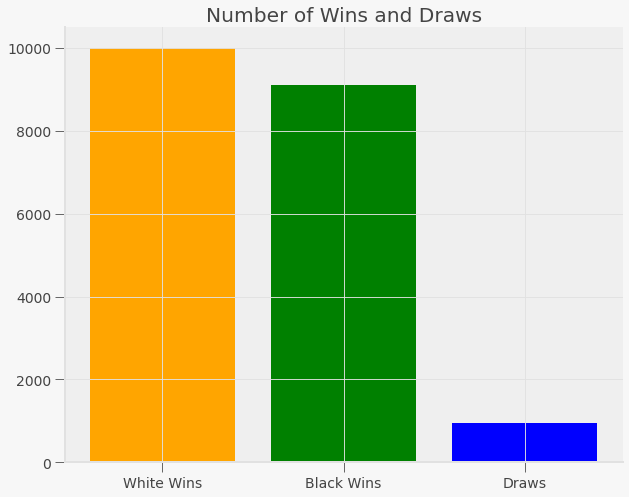

In [148]:
white = chess_clean[chess_clean.winner == 'white']
black = chess_clean[chess_clean.winner == 'black']

mate_ = chess_clean.victory_status.str.count("mate")
out_of_time = chess_clean.victory_status.str.count("outoftime")
resign_ = chess_clean.victory_status.str.count("resign")

white_win = chess_clean.winner.str.count("white").sum()
black_win = chess_clean.winner.str.count("black").sum()
draw = chess_clean.winner.str.count("draw").sum()

white_mate = white.victory_status.str.count("mate").sum()
white_resign = white.victory_status.str.count("resign").sum()
white_time = white.victory_status.str.count("outoftime").sum()

black_mate = black.victory_status.str.count("mate").sum()
black_resign = black.victory_status.str.count("resign").sum()
black_time = black.victory_status.str.count("outoftime").sum()


games = white_win + black_win + draw

w_rate = (white_win / games) * 100
b_rate = (black_win / games) * 100
d_rate = (draw / games) * 100

print(f"Out of {games} games, white won a total of {white_win} times, black won a total of {black_win} times, and there were {draw} draws")

print(f"The win rates for white and black are {w_rate:.2f}% and {b_rate:.2f}% respectively, the rate of draws was {d_rate:.2f}%")

x_val = [white_win, black_win, draw]
color = ['orange', 'green', 'blue']

plt.bar(['White Wins', 'Black Wins', 'Draws'], x_val, color = color)
plt.title('Number of Wins and Draws')
plt.show()

### Average Skill Rating of Players

This quickly just shows that on average, white player ratings are higher than the black player rating. As I am not sure on the rules used for these games I cannot say whether the higher ranked player gets to pick their colour or not.

In [149]:
#checking the mean value of the rating difference to see if there is a trend in white having a stronger rating on average in their wins

white_avg = chess_clean['white_rating'].mean()
black_avg = chess_clean['black_rating'].mean()


print(f"The average skill rating of players with white pieces is {white_avg:.2f} and the average skill rating of players using black pieces is {black_avg:.2f}")


The average skill rating of players with white pieces is 1596.63 and the average skill rating of players using black pieces is 1588.83


Here is a visual representation of the above data which can show the proportions of what colour is winning more and with what way that the game was won. White wins totaled 10001 and black wins totaled 9107 a breakdown of these wins can be seen in the pie chart below. All previous cells must be run before this one. I do not have a title for the graph as this explanation give enough information to know what it's about. This cell below uses data from previous cells, please run all cells before this.

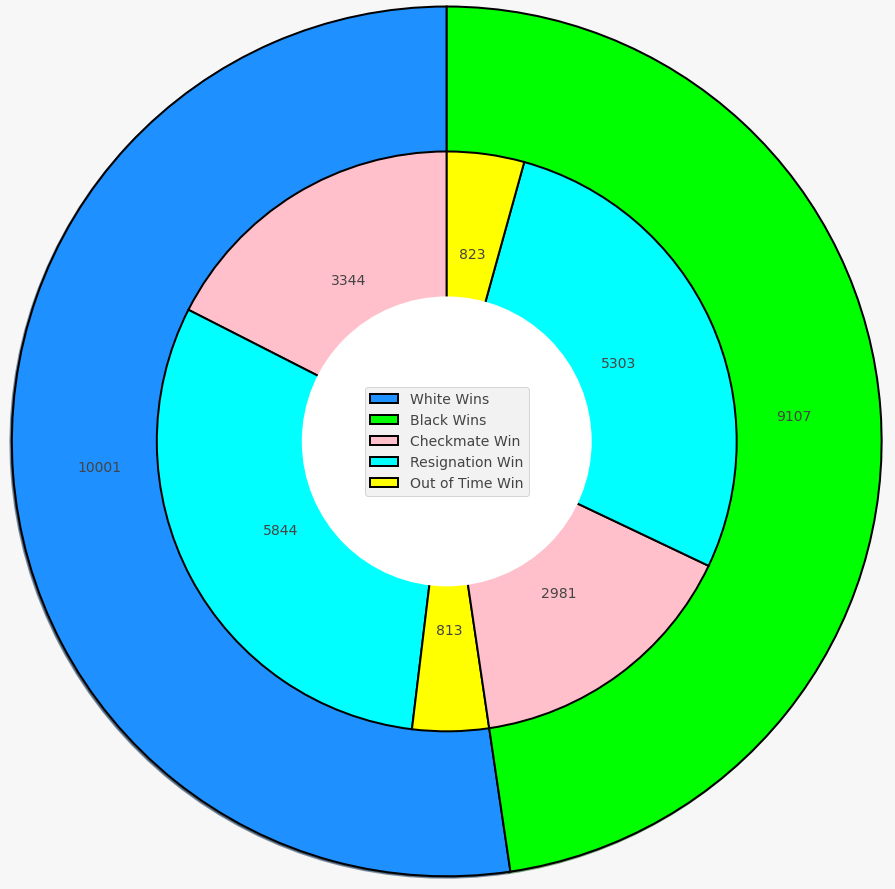

In [150]:
fig, ax = plt.subplots()

val_rate = [white_win, black_win]
labels = ["White Wins", "Black Wins", "Checkmate Win", "Resignation Win", "Out of Time Win"]
color = ['dodgerblue','lime']
explode = (0.05,0.05)

val_win = [white_mate, white_resign, white_time, black_mate, black_resign, black_time]
color_win = ['pink', 'cyan', 'yellow', 'pink', 'cyan', 'yellow']
sizes = [white_mate, white_resign, white_time, black_mate, black_resign, black_time]

#autopct function allows a value to be represented in the pie plot as opposed to a percent

def autopct_format(values):
    def my_format(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        return '{v:d}'.format(v=val)
    return my_format




ax.pie(val_rate, colors = color, shadow = True, startangle = 90, radius = 6, 
       pctdistance= 0.8, autopct= autopct_format(val_rate), wedgeprops={
           "edgecolor":"0",'linewidth': 2, 'linestyle': 'solid', 
           'antialiased': True})

ax.pie(val_win, colors = color_win, shadow = True, startangle = 90, radius = 4,
       autopct= autopct_format(sizes), pctdistance= 0.65, wedgeprops={
           "edgecolor":"0",'linewidth': 2, 'linestyle': 'solid', 'antialiased': True})

centre_circle = plt.Circle((0,0),2,fc='white')
plt.axis([-3, 3, -3, 3])

ax.set_axis_off()
ax.legend(labels, loc = "center")
fig = plt.gcf()
fig.gca().add_artist(centre_circle)


plt.show()


### Number of Moves used in Each Game

Finding the number of moves used in the whole game will show how well a players rating comes into after a game moves past the openings.  This is done through creating a new column that separates each move listed and puts them all into an array called split_moves.  Another new column is made, total_moves that counts the length of the array and returns an integer value that gives the total number of moves used.  The former column, split_moves, is then dropped as it is no longer needed. 

In [151]:
chess_clean['split_moves'] = chess_clean['moves'].apply(lambda x: x.split(" "))

chess_clean['total_moves'] = chess_clean['split_moves'].apply(lambda x: len(x))

chess_clean.drop('split_moves', axis = 1).head()

,rated,victory_status,winner,white_rating,black_rating,moves,opening_eco,opening_name,opening_ply,total_moves
0,False,outoftime,white,1500,1191,d4 d5 c4 c6 cxd5 e6 dxe6 fxe6 Nf3 Bb4+ Nc3 Ba5...,D10,Slav Defense: Exchange Variation,5,13
1,True,resign,black,1322,1261,d4 Nc6 e4 e5 f4 f6 dxe5 fxe5 fxe5 Nxe5 Qd4 Nc6...,B00,Nimzowitsch Defense: Kennedy Variation,4,16
2,True,mate,white,1496,1500,e4 e5 d3 d6 Be3 c6 Be2 b5 Nd2 a5 a4 c5 axb5 Nc...,C20,King's Pawn Game: Leonardis Variation,3,61
3,True,mate,white,1439,1454,d4 d5 Nf3 Bf5 Nc3 Nf6 Bf4 Ng4 e3 Nc6 Be2 Qd7 O...,D02,Queen's Pawn Game: Zukertort Variation,3,61
4,True,mate,white,1523,1469,e4 e5 Nf3 d6 d4 Nc6 d5 Nb4 a3 Na6 Nc3 Be7 b4 N...,C41,Philidor Defense,5,95


In [152]:
chess_moves = chess_clean.copy()
chess_moves['wins'] = chess_clean.winner.map( {'white': int(1) , 'black': int(1), 'draw': int(0)} )
chess_moves['win_val'] = chess_clean.winner.map( {'white': int(0) , 'black': int(1), 'draw': int(2)} )

In [153]:
chess_moves.groupby('victory_status')[['winner', 'white_rating', 'black_rating', 'total_moves']].head()

,winner,white_rating,black_rating,total_moves
0,white,1500,1191,13
1,black,1322,1261,16
2,white,1496,1500,61
3,white,1439,1454,61
4,white,1523,1469,95
5,draw,1250,1002,5
6,white,1520,1423,33
7,black,1413,2108,9
8,black,1439,1392,66
9,white,1381,1209,119


As I am only interested in wins, I am removing all results that ended in a draw. I then create a new column called win_val which gives a value of 1 to all wins, regardless of piece colour and type, so I can more easily sum the amount of wins that each black and white had seperately. This will also allow for an easier summation of opening_eco wins as I can use the groupby function from pandas then sum the number of wins.

I am also splitting the data into two completely new dataframes associated with each colour piece.  This will be to allow someone to see how each colours statistics compare to eachother. First up the dataset associated towards white piece winners.

In [154]:
chess_move_clean = chess_moves[~chess_moves.winner.str.contains("draw")]
chess_move_clean.drop('moves', axis = 1).head()

,rated,victory_status,winner,white_rating,black_rating,opening_eco,opening_name,opening_ply,split_moves,total_moves,wins,win_val
0,False,outoftime,white,1500,1191,D10,Slav Defense: Exchange Variation,5,"[d4, d5, c4, c6, cxd5, e6, dxe6, fxe6, Nf3, Bb...",13,1,0
1,True,resign,black,1322,1261,B00,Nimzowitsch Defense: Kennedy Variation,4,"[d4, Nc6, e4, e5, f4, f6, dxe5, fxe5, fxe5, Nx...",16,1,1
2,True,mate,white,1496,1500,C20,King's Pawn Game: Leonardis Variation,3,"[e4, e5, d3, d6, Be3, c6, Be2, b5, Nd2, a5, a4...",61,1,0
3,True,mate,white,1439,1454,D02,Queen's Pawn Game: Zukertort Variation,3,"[d4, d5, Nf3, Bf5, Nc3, Nf6, Bf4, Ng4, e3, Nc6...",61,1,0
4,True,mate,white,1523,1469,C41,Philidor Defense,5,"[e4, e5, Nf3, d6, d4, Nc6, d5, Nb4, a3, Na6, N...",95,1,0


Finding the difference between skill ratings will allow me to see if the higher rated player won or not.  If the value is positive the higher ranked player won, if it is negative the lower ranked player won. 

In [155]:
white_diff = white.copy()
white_diff['split_moves'] = white_diff['moves'].apply(lambda x: x.split(" "))
white_diff['total_moves'] = white_diff['split_moves'].apply(lambda x: len(x))
white_diff['rating_diff'] = (white_diff['white_rating'] - white_diff['black_rating'])
white_diff.drop('moves', axis = 1).head()

,rated,victory_status,winner,white_rating,black_rating,opening_eco,opening_name,opening_ply,split_moves,total_moves,rating_diff
0,False,outoftime,white,1500,1191,D10,Slav Defense: Exchange Variation,5,"[d4, d5, c4, c6, cxd5, e6, dxe6, fxe6, Nf3, Bb...",13,309
2,True,mate,white,1496,1500,C20,King's Pawn Game: Leonardis Variation,3,"[e4, e5, d3, d6, Be3, c6, Be2, b5, Nd2, a5, a4...",61,-4
3,True,mate,white,1439,1454,D02,Queen's Pawn Game: Zukertort Variation,3,"[d4, d5, Nf3, Bf5, Nc3, Nf6, Bf4, Ng4, e3, Nc6...",61,-15
4,True,mate,white,1523,1469,C41,Philidor Defense,5,"[e4, e5, Nf3, d6, d4, Nc6, d5, Nb4, a3, Na6, N...",95,54
6,True,resign,white,1520,1423,D00,Blackmar-Diemer Gambit: Pietrowsky Defense,10,"[d4, d5, e4, dxe4, Nc3, Nf6, f3, exf3, Nxf3, N...",33,97


Text(0, 0.5, 'Number of Wins')

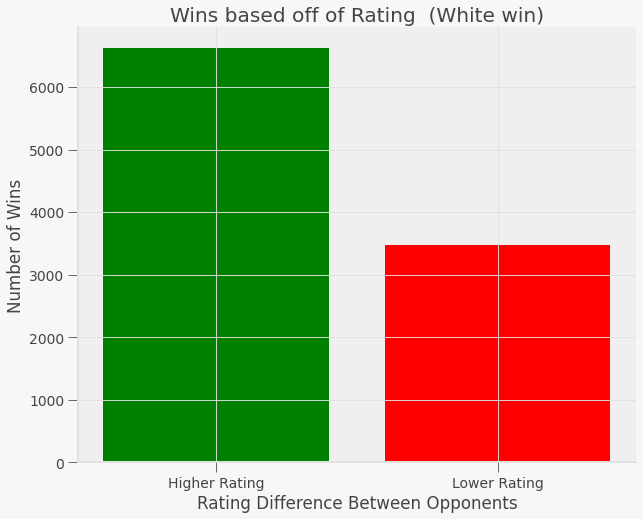

In [156]:
white_diff.loc[white_diff['rating_diff'] >= 0, 'pos_diff'] = 1 
white_diff.loc[white_diff['rating_diff'] <= 0, 'neg_diff'] = 1
white_diff['neg_diff'].replace(np.nan, 0)
white_diff['neg_diff'] = white_diff['neg_diff'].fillna(0)
white_diff['pos_diff'] = white_diff['pos_diff'].fillna(0)
y = np.array([white_diff['pos_diff'].sum(), white_diff['neg_diff'].sum()])
x_tick = ['Higher Rating', 'Lower Rating']
colors_1 = ['g', 'r']
plt.bar(x_tick, y, color = colors_1)
plt.title('Wins based off of Rating  (White win)')
plt.xlabel('Rating Difference Between Opponents')
plt.ylabel('Number of Wins')

As you can see here the higher rated player wins most of the time which is expected, however we don't see how big the difference is in rating with each respective win through this graph. Below will be a function that gives ranges of skill difference and the number of wins encountered for each grouping.

Next comes grouping the amount of wins that each rating difference had. This will just give some general information into how many games have close or far ratings between players.

In [157]:
group_diff = white_diff.copy()
white_group_diff = group_diff.drop(['rated', 'victory_status', 'winner', 'moves', 'opening_eco', 'opening_name', 'opening_ply', 'split_moves', 'total_moves'], axis = 1)
white_group_diff = (white_group_diff['rating_diff'])

In [158]:
def grouping(s, col = 'rating_diff'):
    if np.abs(s) >= 500: 
        col = '> 500'
    elif np.abs(s) >= 300:
        col = '> 300 and < 500'
    elif np.abs(s) >= 100:
        col = '> 100 and < 300'
    elif np.abs(s) >= 50:
        col = '> 50 and < 100'
    else :
        col = '> 0 and < 50'

    return col

In [159]:
white_group_diff.to_frame().head()


,rating_diff
0,309
2,-4
3,-15
4,54
6,97


Text(0, 0.5, 'Player Rating Difference')

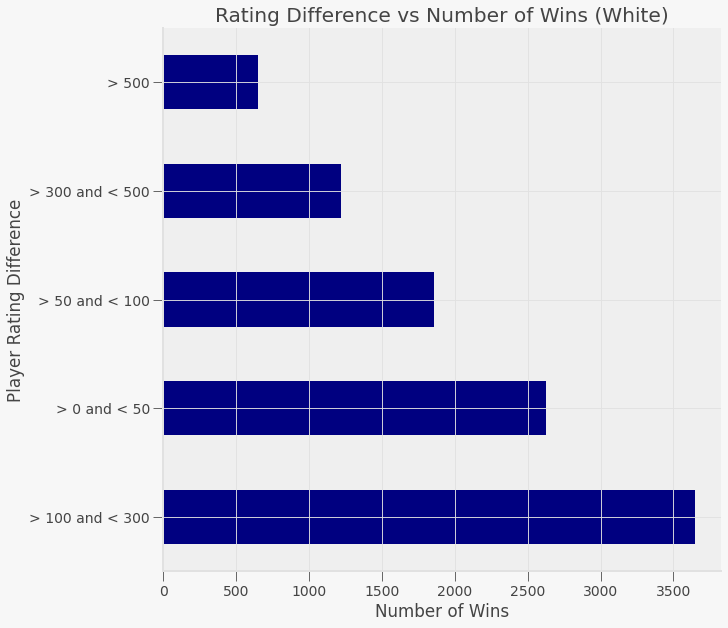

In [160]:
new = white_group_diff.apply(grouping)
new_frame = new.to_frame()
ax = new_frame.rating_diff.value_counts().plot(kind = 'barh', title = 'Rating Difference vs Number of Wins (White)', colormap = 'jet', figsize = (10, 10))
ax.set_xlabel('Number of Wins')
ax.set_ylabel('Player Rating Difference')


Text(0.5, 1.0, 'Total Moves vs. Rating Difference between Players (White Win)')

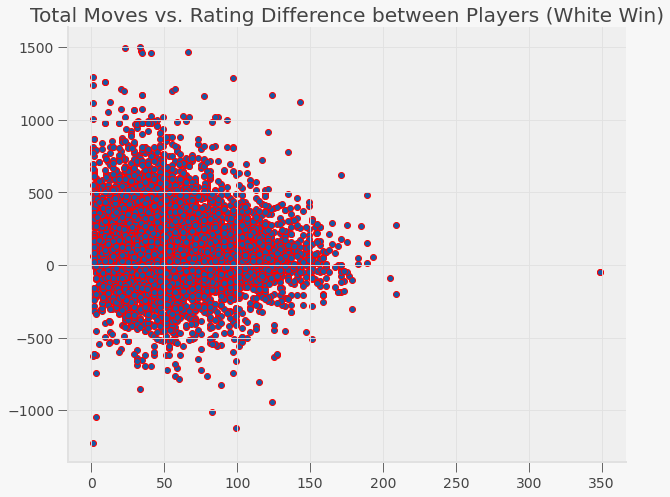

In [161]:
x_val = np.array(white_diff['total_moves'])
y_val = np.array(white_diff['rating_diff'])


plt.scatter(x_val, y_val, linewidths = True, edgecolors = 'r')

plt.title('Total Moves vs. Rating Difference between Players (White Win)')

# This graph is showing all the winners who played with the colour white. This graph is trying to show 
# any relationship that can be seen by how deep a game goes with the difference in player rating.
# This is done for both white and black pieces.



In the above graph we can see a trend forming in that the larger the skill rating difference typically the shorter the game.  Longer games are typically between players with closer skill ratings.  This can be expected as a large discrepancy in skill should result in a faster game while the closer rated games should be more drawn out as each player will likely be familiar with moves used by one another.  The outlier is removed later to give a better representation of the graph compared to the black wins one.

In [162]:
black_diff = black.copy()
black_diff['split_moves'] = black_diff['moves'].apply(lambda x: x.split(" "))
black_diff['total_moves'] = black_diff['split_moves'].apply(lambda x: len(x))
black_diff['rating_diff'] = (black_diff['black_rating'] - black_diff['white_rating'])
black_diff.drop('moves', axis = 1).head()

,rated,victory_status,winner,white_rating,black_rating,opening_eco,opening_name,opening_ply,split_moves,total_moves,rating_diff
1,True,resign,black,1322,1261,B00,Nimzowitsch Defense: Kennedy Variation,4,"[d4, Nc6, e4, e5, f4, f6, dxe5, fxe5, fxe5, Nx...",16,-61
7,False,resign,black,1413,2108,B00,Nimzowitsch Defense: Kennedy Variation | Link...,5,"[e4, Nc6, d4, e5, d5, Nce7, c3, Ng6, b4]",9,695
8,True,resign,black,1439,1392,C50,Italian Game: Schilling-Kostic Gambit,6,"[e4, e5, Bc4, Nc6, Nf3, Nd4, d3, Nxf3+, Qxf3, ...",66,-47
11,False,resign,black,1381,1867,C02,French Defense: Advance Variation | Paulsen A...,9,"[e4, e6, d4, d5, e5, c5, c3, Nc6, Nf3, Qb6, Be...",38,486
12,False,resign,black,1381,1936,C00,French Defense: Knight Variation,3,"[e4, e6, Nf3, d5, exd5, exd5, Qe2+, Be7, Nc3, ...",60,555


Text(0, 0.5, 'Number of Wins')

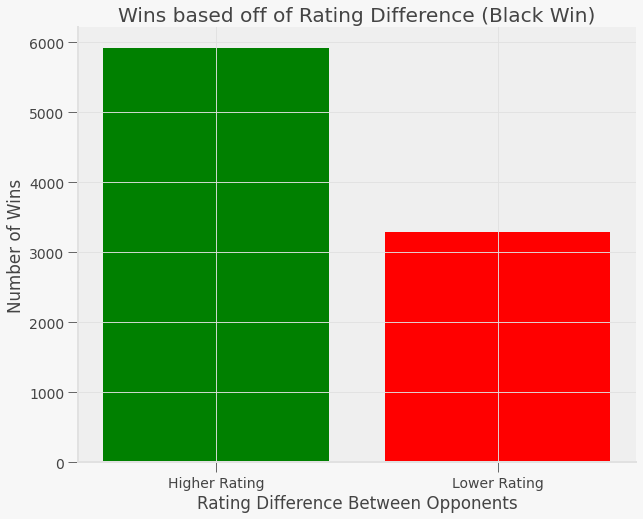

In [163]:
black_diff.loc[black_diff['rating_diff'] >= 0, 'pos_diff'] = 1 
black_diff.loc[black_diff['rating_diff'] <= 0, 'neg_diff'] = 1
black_diff['neg_diff'].replace(np.nan, 0)
black_diff['neg_diff'] = black_diff['neg_diff'].fillna(0)
black_diff['pos_diff'] = black_diff['pos_diff'].fillna(0)
y = np.array([black_diff['pos_diff'].sum(), black_diff['neg_diff'].sum()])
x_tick = ['Higher Rating', 'Lower Rating']
colors_1 = ['g', 'r']
plt.bar(x_tick, y, color = colors_1)
plt.title('Wins based off of Rating Difference (Black Win)')
plt.xlabel('Rating Difference Between Opponents')
plt.ylabel('Number of Wins')

In [164]:
black_diff['neg_diff'] = (black_diff['rating_diff'] > 0)
black_diff['neg_diff'].value_counts()

True     5823
False    3284
Name: neg_diff, dtype: int64

Text(0, 0.5, 'Player Rating Difference')

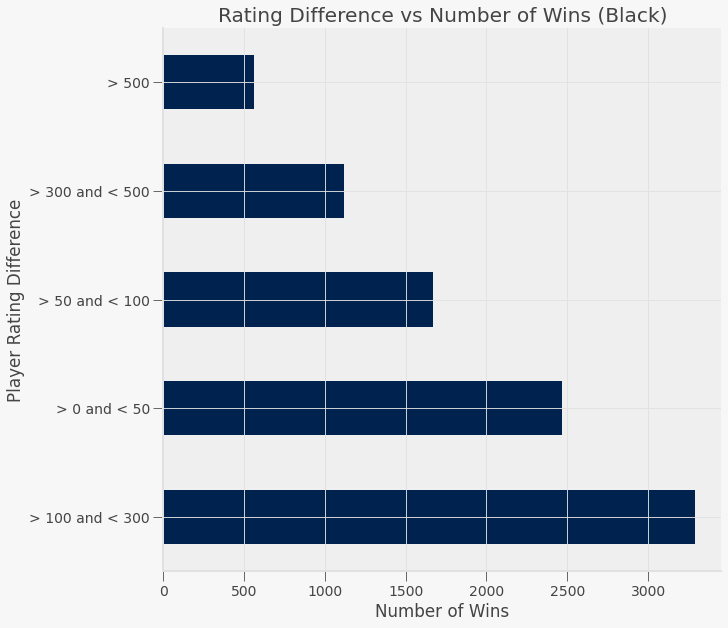

In [165]:
group_diff = black_diff.copy()
black_group_diff = group_diff.drop(['rated', 'victory_status', 'winner', 'moves', 'opening_eco', 'opening_name', 'opening_ply', 'split_moves', 'total_moves'], axis = 1)
black_group_diff = (black_group_diff['rating_diff'])
new2 = black_group_diff.apply(grouping)
new_frame2 = new2.to_frame()
ax2 = new_frame2.rating_diff.value_counts().plot(kind = 'barh', title = 'Rating Difference vs Number of Wins (Black)', colormap = 'cividis', figsize = (10, 10))
ax2.set_xlabel('Number of Wins')
ax2.set_ylabel('Player Rating Difference')

Text(0.5, 1.0, 'Total Moves vs. Rating Difference between Players (Black Win)')

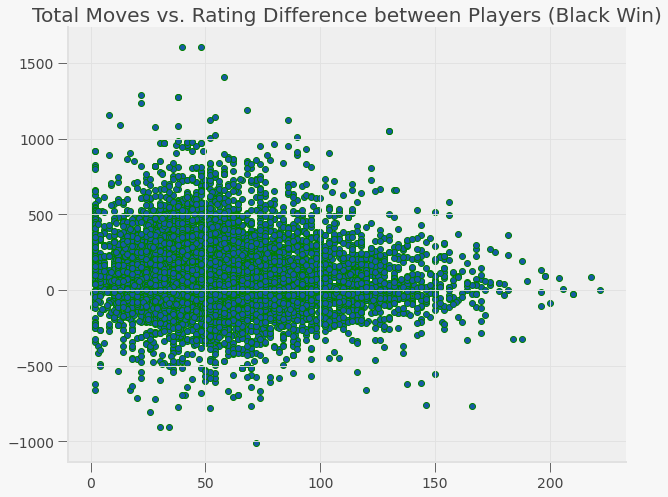

In [166]:
x_val2 = np.array(black_diff['total_moves'])
y_val2 = np.array(black_diff['rating_diff'])
plt.scatter(x_val2, y_val2, linewidths = True, edgecolors = 'g')
plt.title('Total Moves vs. Rating Difference between Players (Black Win)')

From these two graphs we can see a trend that shows the longer a game goes, the closer player skill rating are for both white and black wins. A large difference in ratings between players often relates to a much quicker game, this is fairly intuitive as they would be able to quickly recognize an opponents weakness and exploit that. With white, there is an outlier out over the 300 move mark but removing those would give the same, so I will drop this point from that data set and make a subplot of the two separates graphs for a more direct comparison.


In [167]:
white_diff['total_moves'].max()

349

In [168]:
white_diff.drop(white_diff.loc[white_diff['total_moves']==349].index, inplace=True)

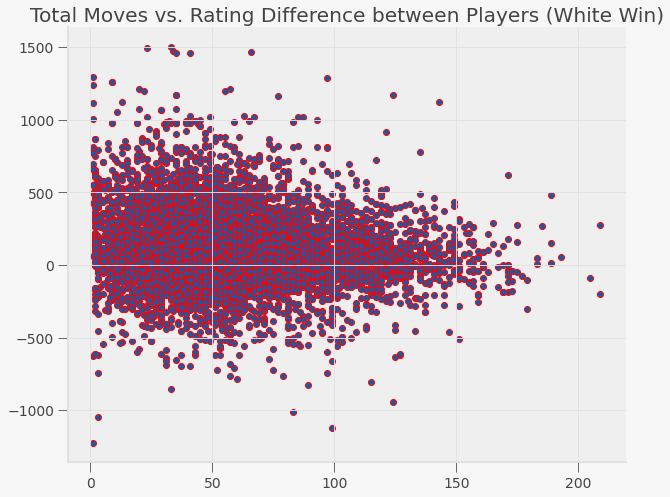

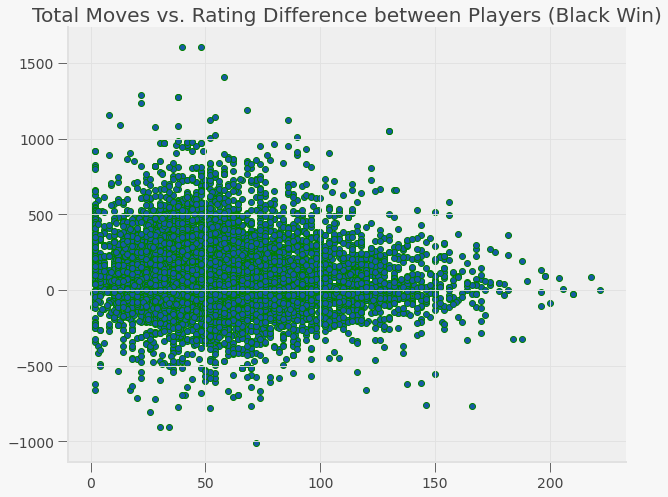

In [169]:
x_val3 = np.array(white_diff['total_moves'])
y_val3 = np.array(white_diff['rating_diff'])

plt.scatter(x_val3, y_val3, linewidths = True, edgecolors = 'r')
plt.title('Total Moves vs. Rating Difference between Players (White Win)')
plt.show()

x_val4 = np.array(black_diff['total_moves'])
y_val4 = np.array(black_diff['rating_diff'])

plt.scatter(x_val2, y_val2, linewidths = True, edgecolors = 'g')
plt.title('Total Moves vs. Rating Difference between Players (Black Win)')
plt.show()


As is much more noticeable now, the graph are of very similar shape and have the same type of trend as mentioned above. Here we can conclude that while the games are fairly spread out ratings wise for games less than 100 moves, it does begin to localize more towards even player ratings the longer a game takes in terms of moves.

### Opening Move Set with Wins

In this section, the goal is to see which move sets are the strongest in terms wins. Weights cannot be distributed with this dataset as all the games reported have a winner associated with that game and the opening that gave that win. This statement applied to win rates specifically, a weight of usage could be applied but that can be determined easily by taking the number of victories associated with that opening and dividing by the total number of games. Since this is ot what I am going for, I exclude it from this analysis. While this is kind of a let down as we wont be able to see win rate efficiency due to a opening move set it may allow us to see which openings tend to get used the most and seem most effective. I can also group openings used based off of skill rating to see if there is any relation to an opening being used by higher rated players and thus is more complex to defend against. Regardless of this, it will give some insight into some of the more polished openers that can be used. Another inquiry is how many moves the opener takes before the game moves into the "out of book" classification which is when the moves being done are not part of any opening set and are thus not logged as a "well known strategy"

First the visual representation of the data to allow an easy view on the most popular openers. Here I use opening_eco which just falls under a more generalized opening classification.  Due to the immense number of variations different openings can have, I thought it best to give a more generalized description for ease of data usage and visualization purposes. I will also be limiting the number of openings used to ones that have 150+ wins as even shortening to opening eco, there is over 300 references of movesets. The list of Opening Eco can been seen at this link https://www.365chess.com/eco.php

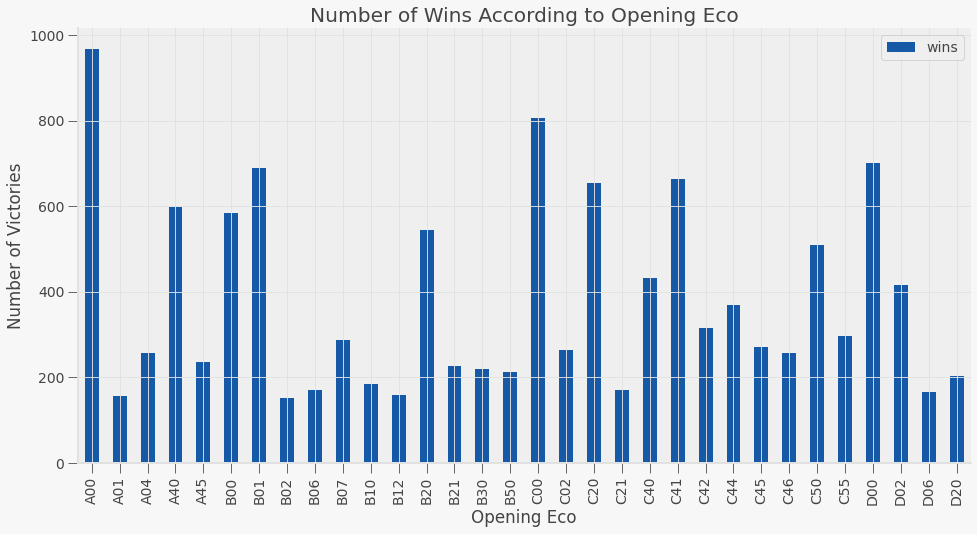

In [170]:

check = chess_move_clean.groupby('opening_eco')[['wins']].sum()
check_plot = check[check.wins>= 150]
check_plot.head()
check_plot.plot(ylabel = 'Number of Victories', xlabel = 'Opening Eco', kind = 'bar', figsize = (16, 8), title = "Number of Wins According to Opening Eco")


Next will be a plot based off of opening_eco used and the mean skill rating of both color players using said opening_eco.  This may give insight into the type of skill set needed to confidently use that type of opening.

In [171]:

grouped = chess_move_clean.groupby('opening_eco')[['win_val']].sum()
avg_white = chess_move_clean.groupby('opening_eco')[['white_rating']].mean()
avg_black = chess_move_clean.groupby('opening_eco')[['black_rating']].mean()
merged = grouped.merge(avg_white, right_index = True, left_index= True)
avg_skill = merged.merge(avg_black, right_index = True, left_index= True)
avg_skill.head()
avg_skill_plot = avg_skill[avg_skill.win_val >= 150]
grouped.describe()

,win_val
count,359.000000
mean,25.367688
std,62.065101
min,0.000000
25%,1.000000
50%,5.000000
75%,18.500000
max,570.000000


Text(0, 0.5, 'Average Player Rating')

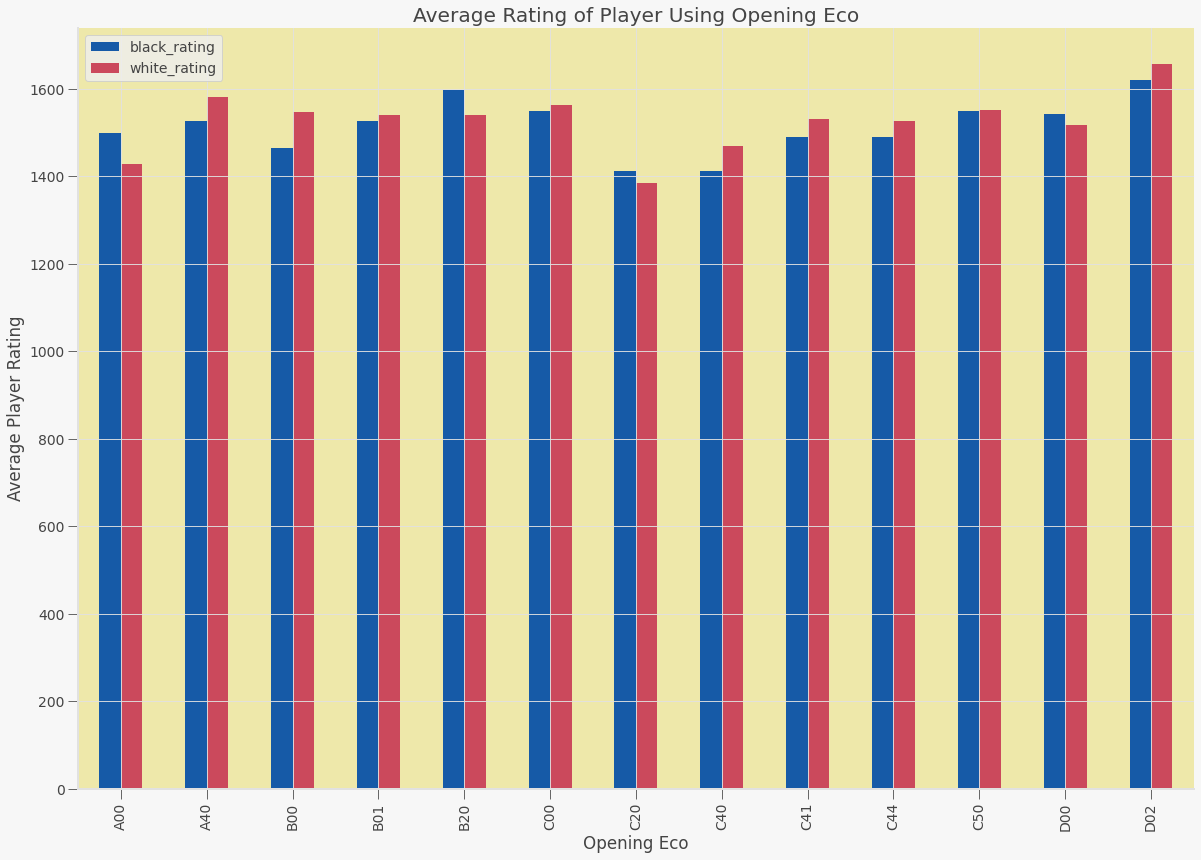

In [172]:
colors = ['r', 'lightseagreen']
fig = (avg_skill_plot.groupby('opening_eco')[['black_rating', 'white_rating']].mean().plot(kind = 'bar',
                 grid = True, figsize = (20, 14)))


fig.set_facecolor('palegoldenrod')
fig.set_title("Average Rating of Player Using Opening Eco")
fig.set_xlabel('Opening Eco')
fig.set_ylabel('Average Player Rating')

With this simple graph, we can get some insight into the average rating that plays a certain opening.  What can potentially be concluded from this graph is how effective an opening is and the average skill needed to use the opening well.  This graphs shows the openings that have 150+ wins as again, I am only interested In the most effective play styles. The code can easily be manipulated to gather data for the other openings.

# Moving Onto Main Analysis

### Logistic Regression

The two processes I will be using for predicting outcome will be Logistic Regression and Random Forest Classification due the discrete nature of the outcome (win, lose, draws are excluded).  Since the columns I intend to use contain many different categories, especially the opening_eco column with over 350 different entries, I will need to convert values to dummy variables.  For the logistic regression analysis I will be doing this with OneHotEncoder which takes care of that process automatically.  The functions below are taken from class lectures and the data is entered and converted to coressponding training and test sets to try and fit the given outcomes of white winning or black winning.

The function below takes in continuous variable which are all the columns, with numerical values as input, and categorical values, which are the columns with string values. The contiunous variables are then stack together without mannipulating the values, the categorical variables are turned into dummy variables by OneHotEncoder and then stacked on to the X matrix.  The variable we are concerned with predicting is then entered as the y-var parameter.
The matrix X and vector y are then run through a model selection module which returns the training data and testing data which will be used throught the Logistic analysis.

In [173]:
def prep_data(df, continuous_variables, categories, y_var, test_size=0.2):

    ohe = preprocessing.OneHotEncoder(sparse=False)

    y = df[y_var].values
    X = np.zeros((y.size, 0))

    # Add continuous variables if exist
    if len(continuous_variables) > 0:
        X = np.hstack([X, df[continuous_variables].values])

    if len(categories) > 0:
        X = np.hstack([X, ohe.fit_transform(df[categories])])

    X_train, X_test, y_train, y_test = model_selection.train_test_split(
        X, y, test_size=test_size, random_state=42
    )

    return X_train, X_test, y_train, y_test, X, y

In [174]:
def fit_and_report_mses(mod, X_train, X_test, y_train, y_test):
    mod.fit(X_train, y_train)
    return dict(
        mse_train=metrics.mean_squared_error(y_train, mod.predict(X_train)),
        mse_test=metrics.mean_squared_error(y_test, mod.predict(X_test))
    )


fit_and_report_mses(linear_model.Lasso(), X_train, X_test, y_train, y_test)

{'mse_test': 0.21642035459724857, 'mse_train': 0.2155574131727231}

Here I am creating a new data frame and cleaning out any of the unnecessary columns that could cause problems when running the analysis. 

In [175]:
chess_test = chess_move_clean.drop(['rated', 'victory_status', 'winner', 'moves', 'opening_name', 'split_moves'], axis = 1)
chess_test

,white_rating,black_rating,opening_eco,opening_ply,total_moves,wins,win_val
0,1500,1191,D10,5,13,1,0
1,1322,1261,B00,4,16,1,1
2,1496,1500,C20,3,61,1,0
3,1439,1454,D02,3,61,1,0
4,1523,1469,C41,5,95,1,0
...,...,...,...,...,...,...,...
20053,1691,1220,A80,2,24,1,0
20054,1233,1196,A41,2,82,1,1
20055,1219,1286,D00,3,35,1,0
20056,1360,1227,B07,4,109,1,0


Running the above function and saving the returned values to the variable for testing these are the sets of variable that form out test set and training set to run the analysis.

In [176]:
X_train, X_test, y_train, y_test, X, y = prep_data(
    chess_test, ['white_rating', 'black_rating', 'opening_ply'], ['opening_eco'],  'win_val'
)

The function below takes the input parameters which will be the returned values from the function above and creates predictions using the logistic regression model.  Once it takes these values it returns a dict with the mean absolute error between the training data and testing data of the predicted y values(yhat_train and yhat_test) and the actual y values(y_train and y_test).

Text(-2.368878992199555, 0.3462645558026953, 'train')

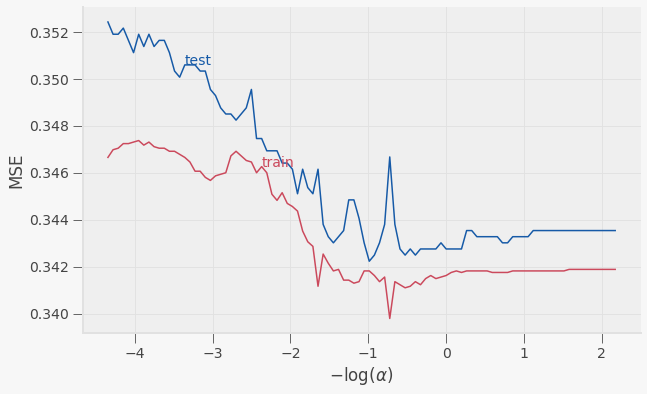

In [177]:
alphas = np.exp(np.linspace(10, -5, 100))
mse = pd.DataFrame([fit_and_report_mses(linear_model.LogisticRegression(penalty='l2' , C=1/alpha, max_iter=50000),
                           X_train, X_test, y_train, y_test)
                    for alpha in alphas])
mse["log_alpha"] = -np.log10(alphas)
fig, ax = plt.subplots(figsize=(10,6))
colors = qeds.themes.COLOR_CYCLE
mse.plot(x="log_alpha", y="mse_test", c=colors[0], ax=ax)
mse.plot(x="log_alpha", y="mse_train", c=colors[1], ax=ax)
ax.set_xlabel(r"$-\log(\alpha)$")
ax.set_ylabel("MSE")
ax.get_legend().remove()
ax.annotate("test",(mse.log_alpha[15], mse.mse_test[15]),color=colors[0])
ax.annotate("train",(mse.log_alpha[30], mse.mse_train[30]),color=colors[1])

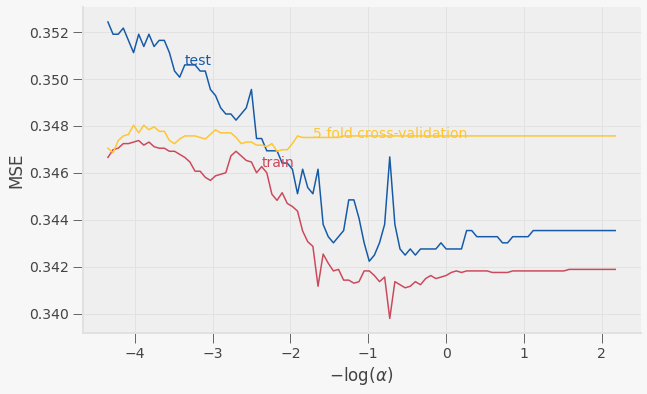

In [178]:
from sklearn.model_selection import cross_val_score
mse["cv"] = [-np.mean(cross_val_score(linear_model.LogisticRegression(penalty='l2' , C=1/alpha, max_iter=50000),
                                  X_train, y_train, cv=5, scoring='neg_mean_squared_error'))
          for alpha in alphas]
mse.plot(x="log_alpha", y="cv", c=colors[2], ax=ax)
ax.annotate("5 fold cross-validation", (mse.log_alpha[40], mse.cv[40]), color=colors[2])
ax.get_legend().remove()
ax.set_xlabel(r"$-\log(\alpha)$")
ax.set_ylabel("MSE")
fig

#### RECALL, Precision, and F1-Score

In [179]:
logreg = linear_model.LogisticRegressionCV(cv=5).fit(X_train, y_train)
logreg_test_score, logreg_train_score = logreg.score(X_train, y_train)*100, logreg.score(X_test, y_test)*100
print(f"The predictive score for the training set is {logreg_test_score:.2f}%, and {logreg_train_score:.2f}% respectively")

The predictive score for the training set is 65.37%, and 65.07% respectively


Using the trained dataset for logistic regression above gives the ability to produce some usuable information from our dataset.  Given the specfic parameters of white_rating, black_rating, opening_ply, and opening_eco the we can check and see the accuracy of the model bby looking at the scores.  The scores tell us how accurate the predictions were on both the training data and testing data.  This score shows the percentage of times the model predicted correctly for each set. 

In [180]:
train_acc = logreg.score(X_train, y_train)
test_acc = logreg.score(X_test, y_test)

train_acc, test_acc                            

(0.6536700248593484, 0.6507064364207221)

As can be seen, these values are both the same percents as the scores mentioned above. This just confirms that the reporting accuracy is the same as reporting the score of both sets. 

Important metrics to report with logistic regression are the precision and recall scores then from that we can get the F1-score.  What these scores will tell us is with precision we can see the same as what was described above. Precision gives the percentage of true positives over the total number of predicted positives. For example, with white wins a true positive would be that the model predicted that white won and the dataset also has that white one. A predicted positive is the total number of times the model predicted white to win regardless of if it won or not.  The same logic applies for black wins. 

With recall we see the number of true positives divided by the number of actual positives. This gives the ratio regardeing the number of positives that were predicted that are correct.  In terms of this dataset, it would be the predicited number of white win where white did actually win, divided by the total number of white wins in the dataset.

The F1-Score is defined as: $$
F1 = 2 \frac{\text{precision} \cdot \text{recall}}{\text{precision} + \text{recall}}
$$

This gives an overall measure of the tests accuracy as a whole.

In [181]:
report = metrics.classification_report(
    y_test, logreg.predict(X_test),
    target_names=["white_win", "black_win"]
)
print(report)

              precision    recall  f1-score   support

   white_win       0.65      0.72      0.68      1990
   black_win       0.65      0.58      0.61      1832

    accuracy                           0.65      3822
   macro avg       0.65      0.65      0.65      3822
weighted avg       0.65      0.65      0.65      3822



Here we see from the report above that the precision of both the black and white predictions is about 65%.  Recall is where things differ with white wins having a recall value of 72% and black wins having a recall of 58%.  Using the descriptions above of recall and accuracy we can conclude that here, logistic regression predicts with an accuracy of about 65% on this dataset.

#### ROC Curve

Using the Receiver Operating Characteristics (ROC) curve can tell us a couple quick things about the how the test performed.  Mainly what i will be using this for is to get a measure of how well this model predicts between white winning and black winning. Or in other words When white wins or loses, or when black wins or loses.  The ROC curve can be used to find Area under the curve of the ROC and return a value for which we can see the total performance measure.

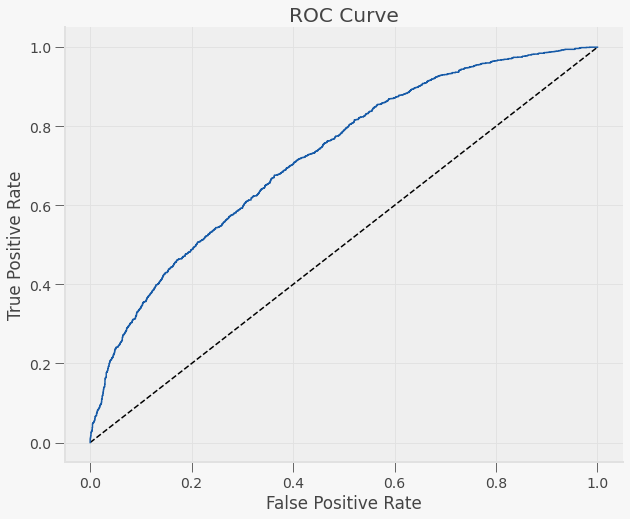

In [182]:
def plot_roc(mod, X, y):
    # predicted_probs is an N x 2 array, where N is number of observations
    # and 2 is number of classes
    predicted_probs = mod.predict_proba(X_test)

    # keep the second column, for label=1
    predicted_prob1 = predicted_probs[:, 1]

    fpr, tpr, _ = metrics.roc_curve(y_test, predicted_prob1)

    # Plot ROC curve
    fig, ax = plt.subplots()
    ax.plot([0, 1], [0, 1], "k--")
    ax.plot(fpr, tpr)
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.set_title("ROC Curve")

plot_roc(logreg, X_test, y_test)

Now that we have the ROC curve visualization, we can try and extract some values from it sing a built in module called roc_auc score. The max AUC score that you can get is 1 whcih would depict a perfect model.  A useless test would be along the 45 degree line, or the dotted line above.  The reason the test would be useless along this line is that the area under it would be 0.5 which is equivalent to blindly guessing the outcome.

In [183]:
predicted_prob1 = logreg.predict_proba(X)[:, 1]
auc = metrics.roc_auc_score(y, predicted_prob1)
print(f"Initial AUC value is {auc:.4f}")

Initial AUC value is 0.7187


Here we have an AUC performance score of 0.7187  which is almost right in between perfect and useless (1 > 0.7187 > 0.5).  This shows that while the model is by no means perfect, it does perform better than just blindly guessing.  The F1-Score also lets us know that the model is better than blindly guessing but this does give a different interpretation to understand what is happening overall.  Now I will be moving on the the RandomForestClassfier analysis.

## Random Forest Classifier

Here I will be using the Random Forest Classifier method as I have a discrete outcome of either win or lose.  To begin this, I explicitly change all my categorical columns and variables into dummy variables.  This splits all the variable into their own columns and if that resepctive row index had one of those values it will be marked with a 1 under that variables column. If it was any of the other values it will be amrked with a 0. 

In [184]:
from sklearn.ensemble import RandomForestClassifier

This function creates the X matrix to be trained and returns a random forest prediction with those corresponding to those values. I remove the win_val column which is what I am trying to predict.  The returned "pre" array will have all the predicted values which will then be compared to actual values to find the difference.

Cleaning up the datarame and concatenating the categorical dummy variables onto the dataframe to allow the model to use everything avaiable.

In [185]:
#cleaning df of string values to be able to use
chess_forest = chess_move_clean.drop(['victory_status', 'moves', 'opening_name', 'split_moves', 'rated', 'winner', 'total_moves'], axis =1)
dummy_df = pd.get_dummies(chess_forest['opening_eco'])
chess_forest = pd.concat([chess_forest, dummy_df], axis = 1)
chess_forest_new = chess_forest.drop('opening_eco', axis = 1)
chess_forest_new

,white_rating,black_rating,opening_ply,wins,win_val,A00,A01,A02,A03,A04,A05,A06,A07,A08,A09,A10,A11,A12,A13,A14,A15,A16,A17,A18,A20,A21,A22,A23,A24,A25,A27,A28,A29,A30,A31,A33,A34,A35,A36,A38,...,E32,E33,E34,E35,E38,E40,E42,E44,E46,E47,E48,E50,E51,E52,E53,E54,E56,E59,E60,E61,E63,E64,E67,E68,E70,E71,E73,E76,E77,E80,E81,E87,E88,E90,E91,E92,E94,E95,E97,E98
0,1500,1191,5,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1322,1261,4,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1496,1500,3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1439,1454,3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1523,1469,5,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20053,1691,1220,2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
20054,1233,1196,2,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
20055,1219,1286,3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
20056,1360,1227,4,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


This is where the actual values are defined to an array y. The X matrix takes the rest of the dataframe with win_val dropped and the training sets are created just as before with logistic regression. The forest function is then called to make the predictions with X and outputs an array with those predicted outcomes.

### Training the Model

In [186]:
forest = RandomForestClassifier(max_depth=12, random_state = 0)

In [187]:
from sklearn.model_selection import train_test_split
y = np.array(chess_forest_new['win_val'])
X = chess_forest_new.drop('win_val', axis = 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
forest.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=12, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

Now that the model is trained we can dissect some information out of it through built in functions.

In [188]:
train_score_full = forest.score(X_train, y_train)
test_score_full = forest.score(X_test, y_test)
print("Scoring with full trees, Train Score: {} Test MSE: {}".format(train_score_full, test_score_full))

Scoring with full trees, Train Score: 0.7080373831775701 Test MSE: 0.6326530612244898


Finding the score, just as with logistic regresion, gives an interpretation on how well the prediction process ran.  Here we see a large difference in the accuracy of these training and testing data. This points to overfitting.

Before moving forward I would like to check for some overfitting. This can be done by checking the MSE of the training and testing data. If the MSE of the test data is much larger than the MSE of the training data there is amost likely an occurance of over fitting.

In [189]:
from sklearn.metrics import mean_squared_error
y_train_predicted = forest.predict(X_train)
y_test_predicted_full_trees = forest.predict(X_test)
mse_train = mean_squared_error(y_train, y_train_predicted)
mse_test = mean_squared_error(y_test, y_test_predicted_full_trees)
print("RF with full trees, Train MSE: {} Test MSE: {}".format(mse_train, mse_test))

RF with full trees, Train MSE: 0.2919626168224299 Test MSE: 0.3673469387755102


While the difference in MSE between these two values may not seem large, we can check for some overfitting by pruning the trees and checking the MSE again . Once we prune the tree, if the MSE of the training and testing sets are much closer in value, we can assume that the model was indeed overfitting and we can move forward by using the pruned trees.  To prune the tree we can increase the minimum number of leafs needed to form a tree.

In [190]:
forest2 = RandomForestClassifier(max_depth=12, random_state = 0, min_samples_leaf=30)
from sklearn.model_selection import train_test_split
y = np.array(chess_forest_new['win_val'])
X = chess_forest_new.drop('win_val', axis = 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
forest2.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=12, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=30, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [191]:
train_score_full2 = forest2.score(X_train, y_train)
test_score_full2 = forest2.score(X_test, y_test)
print("Scoring with pruned trees, Train Score: {} Test MSE: {}".format(train_score_full2, test_score_full2))

Scoring with pruned trees, Train Score: 0.618766355140187 Test MSE: 0.5993371707657422


In [192]:

forest2.fit(X_train, y_train)
y_train_predicted = forest2.predict(X_train)
y_test_predicted_pruned_trees = forest2.predict(X_test)
mse_train = mean_squared_error(y_train, y_train_predicted)
mse_test = mean_squared_error(y_test, y_test_predicted_pruned_trees)
print("RF with pruned trees, Train MSE: {} Test MSE: {}".format(mse_train, mse_test))

RF with pruned trees, Train MSE: 0.3812336448598131 Test MSE: 0.4006628292342578


Here we can see that with an increase in the number of leafs per sample gives a affect the MSE of both scores enough so that they become much closer than before.  This definitely shows some cases of overfitting.  With a change in the 
minimum leafs per sample, the training and testing set become more in sync.

What we can also do to visualize the complexity of each decision is create a plot of the Random Forest with all the branches that com along with it. I will plot both the full tree, and the pruned tree so that the difference can be easily seen.

In [193]:
# re-importing to make sure all modeules are loaded in

import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer
from sklearn import tree
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split


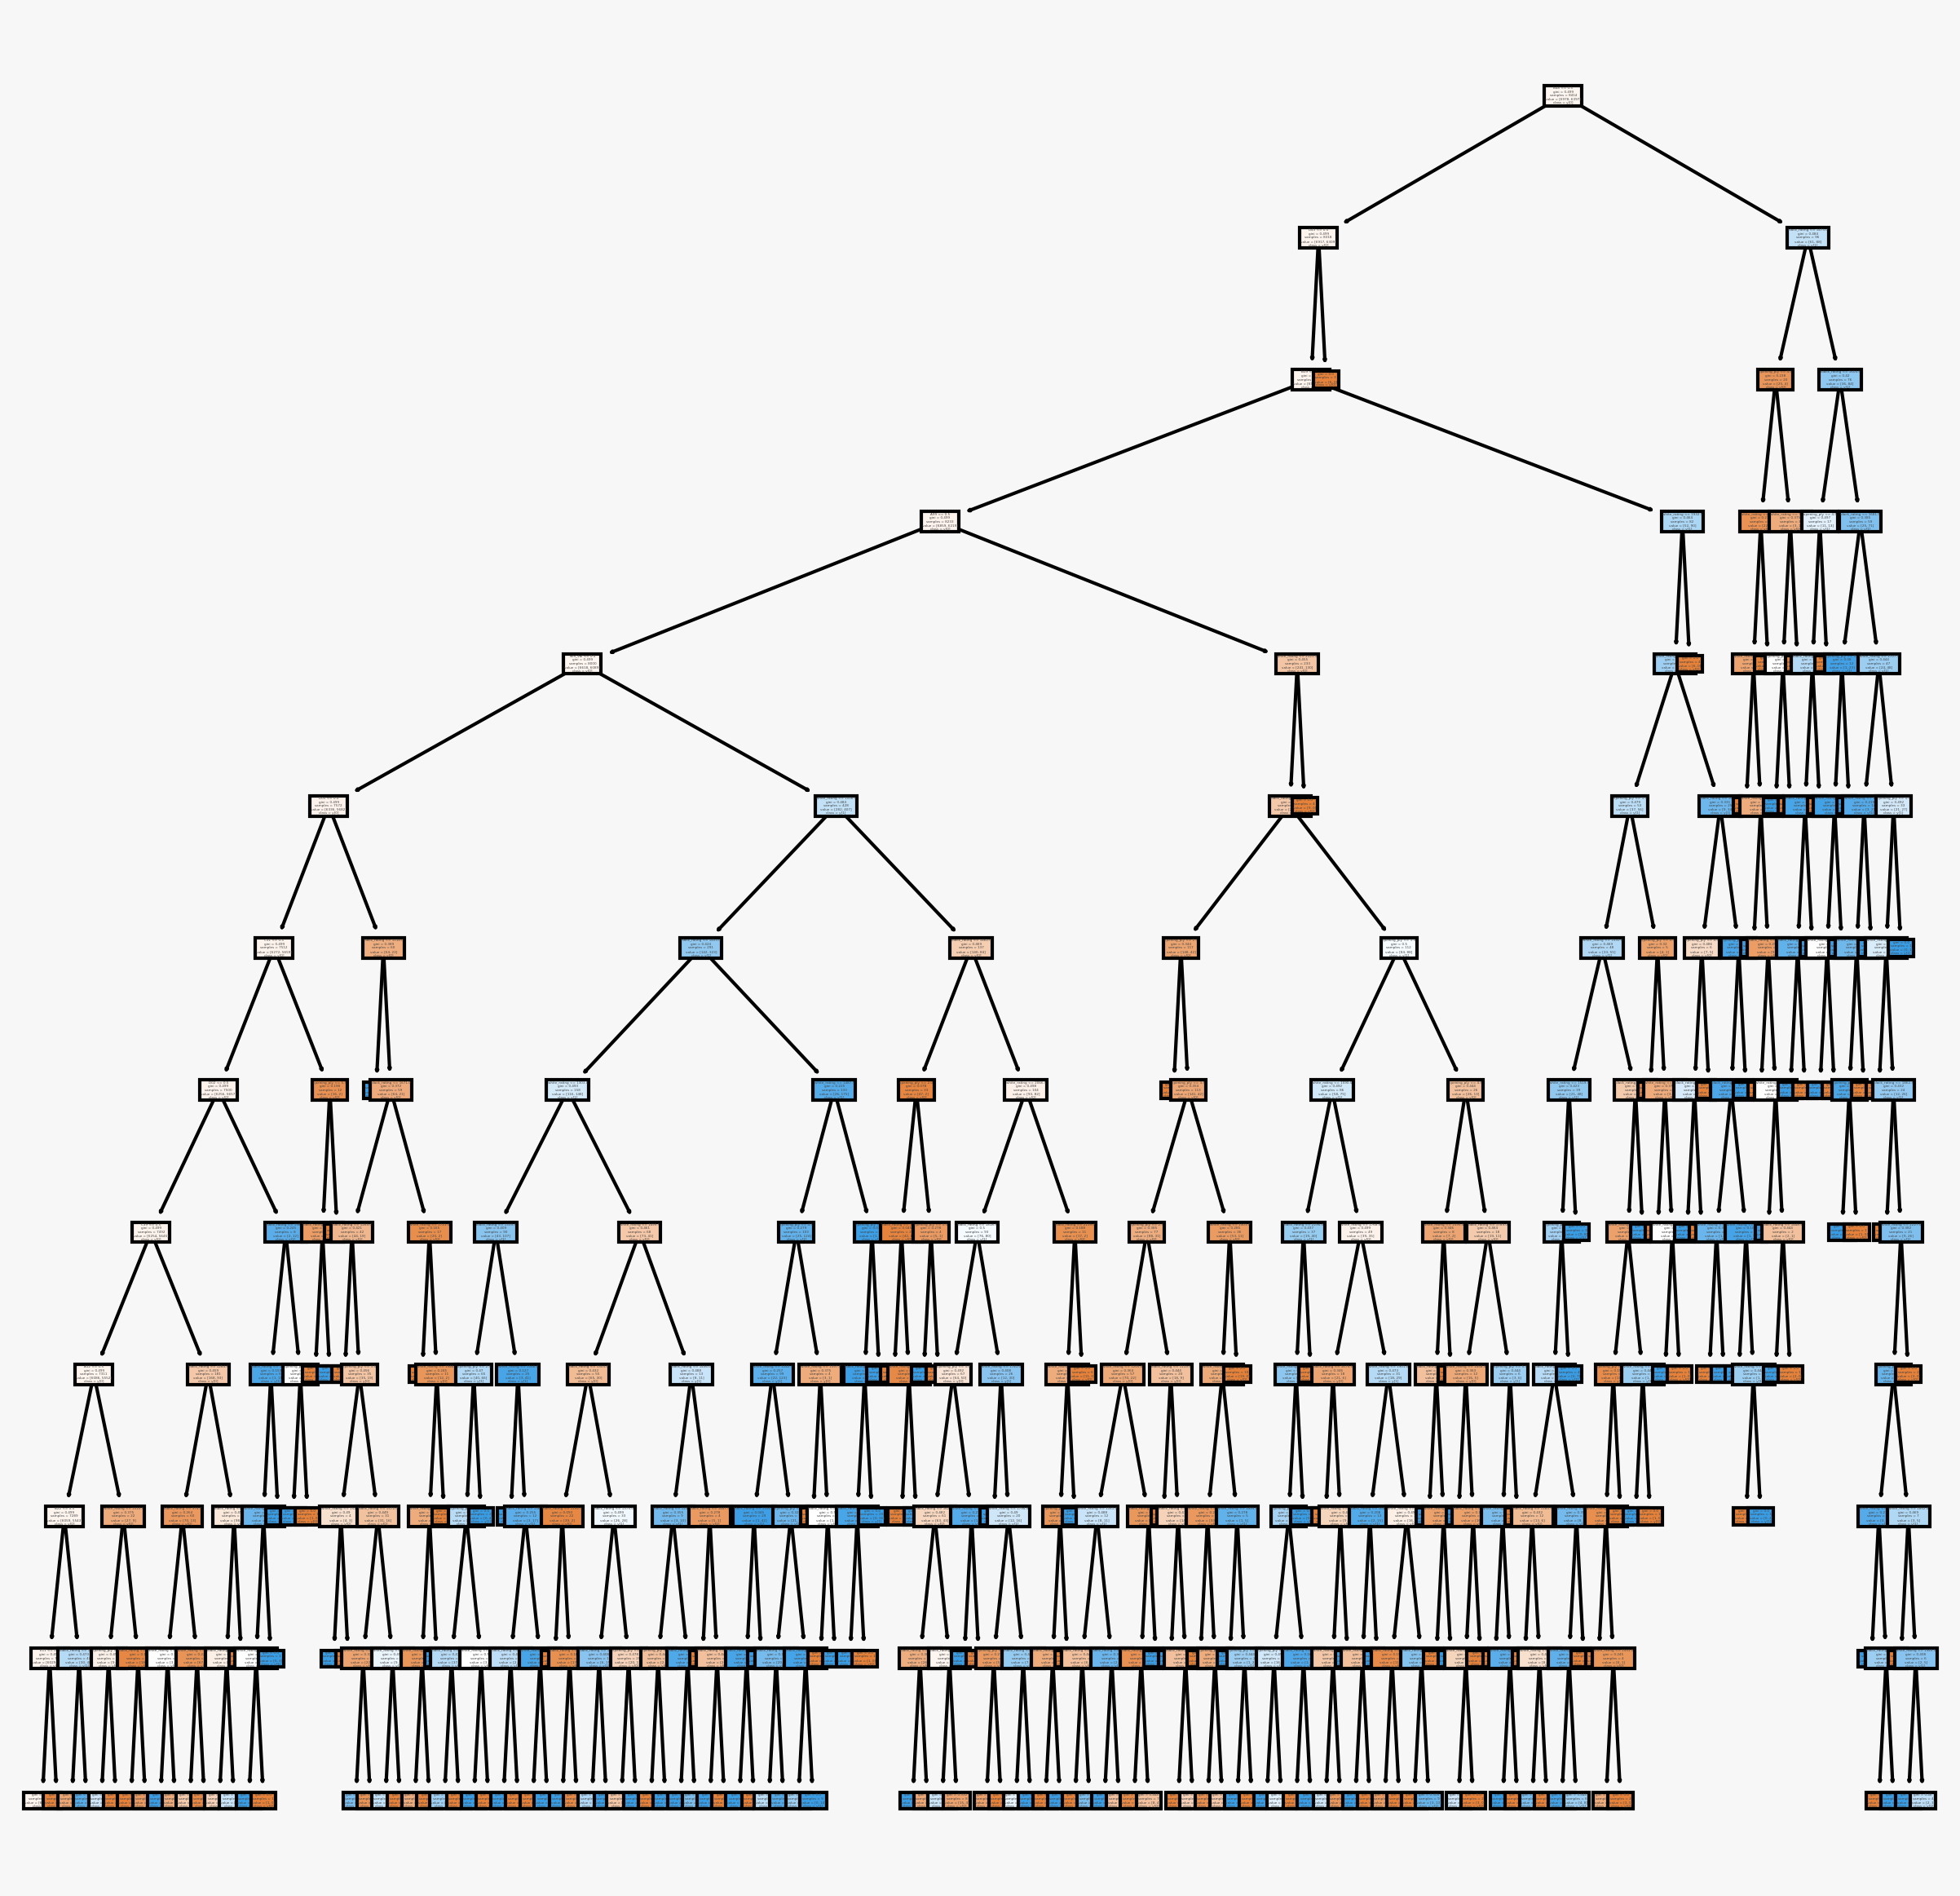

In [194]:
fn=chess_forest_new.columns[:]
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (10,10), dpi=300)
tree.plot_tree(forest.estimators_[0],
               feature_names = fn, 
               class_names=True,
               filled = True);
fig.savefig('rf_individualtree.png')

As it can be seen, with all of the parameters and variable in the dataset the decision process is quite extensive in the first tree figure.  While the tree is unreadable the code can be changed around to make it much more easy to visualize, which has been done with the pruned tree. Now, the pruned tree.

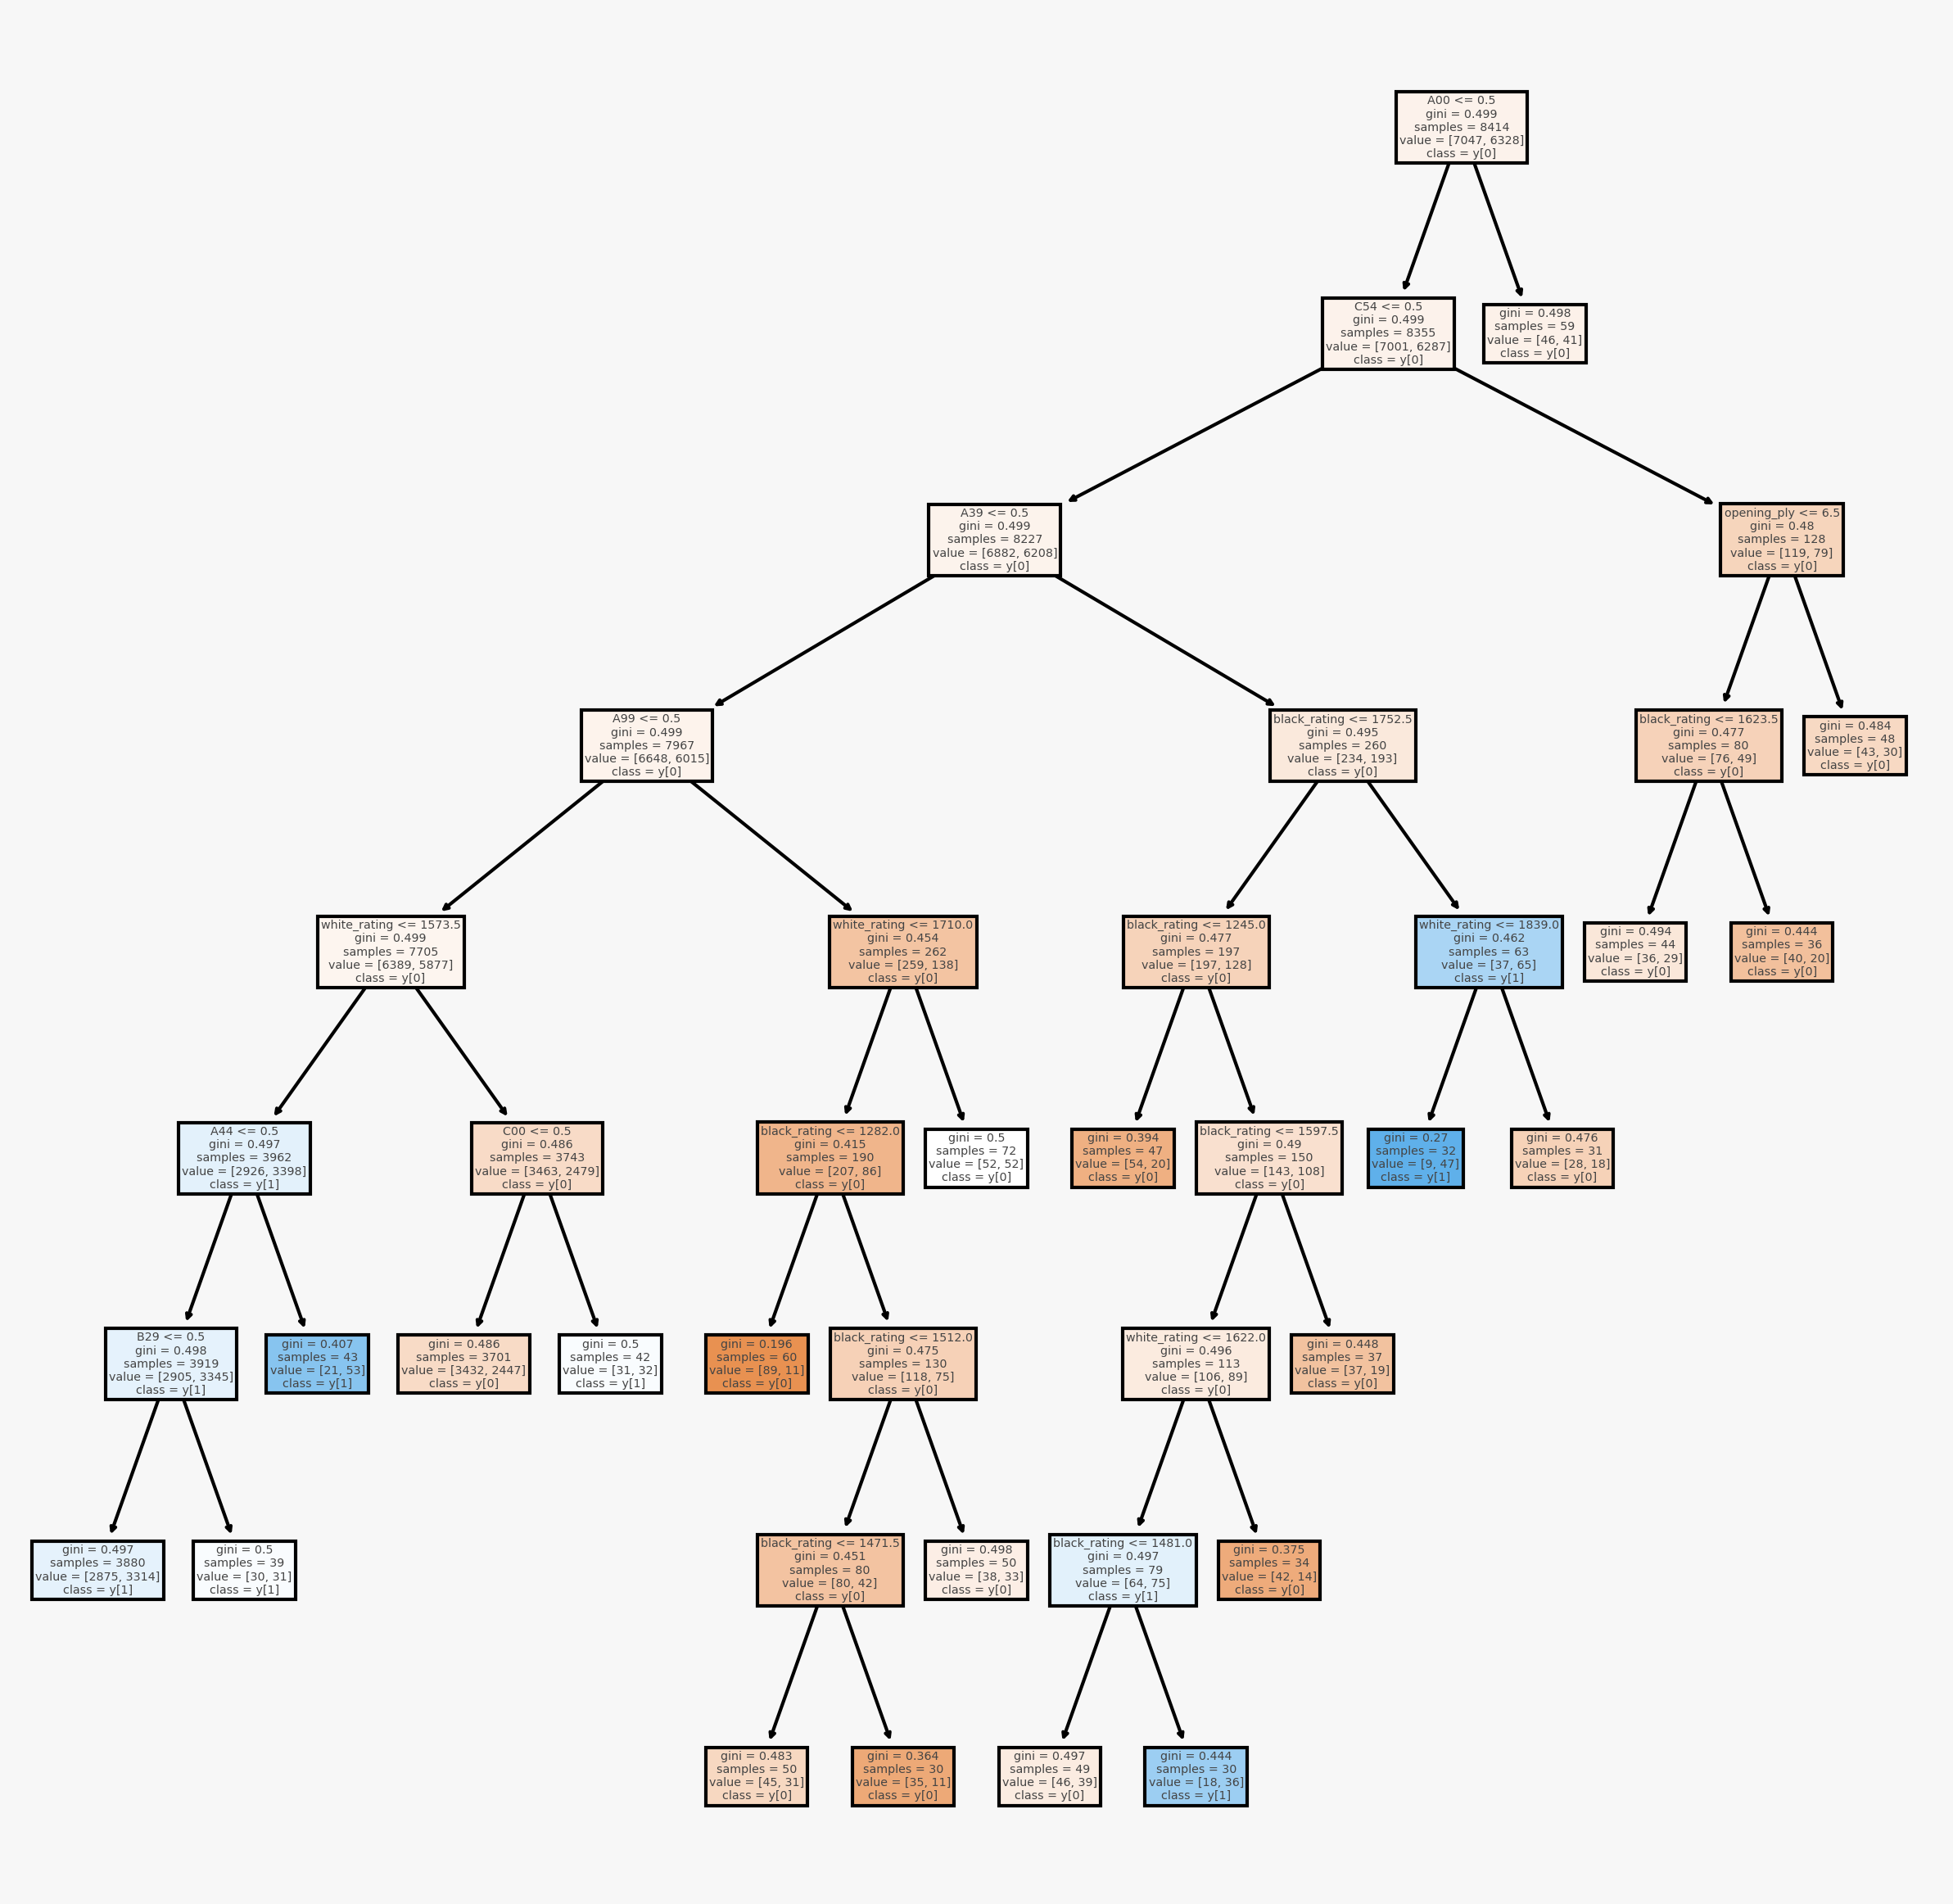

In [195]:
fn=chess_forest_new.columns[:]
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (10,10), dpi=300)
tree.plot_tree(forest2.estimators_[0],
               feature_names = fn, 
               class_names=True,
               filled = True);
fig.savefig('rf_individualtree.png')

Another visualization that can be one is using scatter plots of the predicted outcomes and the actual outcomes and looking for overlap in the two data sets.  Each overlap would be an instance of the model guessing correctly, where as standalone dots would not be a correct prediction.  I will be taking slices of the first 200 instances for ease of reading. *Note while it may look like there is more or less than 60% score accuracy from the pruned tree score, this is only 200 samples out of thousands of entries. A graph of the full set would show that this averages out.

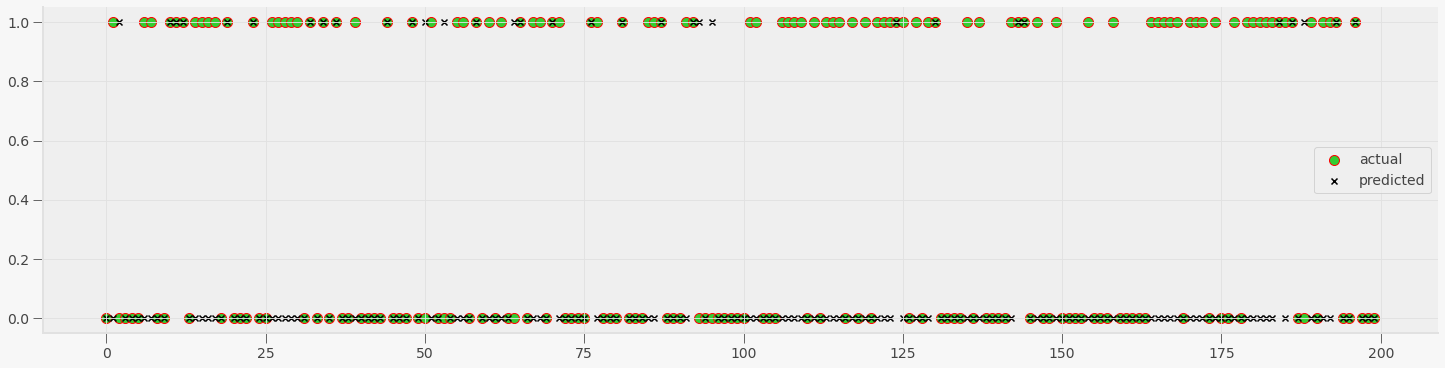

In [196]:
pred_val = forest2.predict(X)
val_check = pred_val[0:200]
check_plot = chess_move_clean['win_val'][0:200]
plt.figure(figsize=(25,6))
plt.scatter(np.arange(0, len(check_plot)), check_plot, color= 'limegreen', marker = 'o', s = 100, edgecolor = 'r')
plt.scatter(np.arange(0, len(val_check)), val_check, color = 'k', marker = 'x')
labels = ('actual', 'predicted')
plt.legend(labels, loc = 'best')
plt.show()

Each green circle wrapped in red is the actual outcome of that respective game and the X's are the predicited outcome of that game. 

# Conclusion

Both processes worked quite well with the dataset and gave some different insights into the game of chess.  While both processes were not flawless, with Logistic Regression having an overall performance score of about 65% and the Random Forest Classifier having a performance score of about 62%, they're definitely better than guessing at random. The models could definitely use some improvements to give better predictive outcomes. These could be having specific player information and player tendencies to influence the dataset more and give more data that would affect a game of chess.  While there is a lot of columns and categorical features in this dataset, a mojority of them are only known after the game itself starts thus how can they predict the outcome of a game that hasnt started yet.  While this was a little dissapointing in terms of usability, the outcome was still promising in the sense of being better than just guessing black wins or white wins. While I didn't really expect to be able to predict allof the outcomes, I was happy with the 60+% accuracy of the models and this project did give quite a bit of insight working with dataframes and into the game of chess itself. In the beginning before any of the classification/regression analysis, it was quite interesting to see the different win rates of white vs. black, the spread of win types, the average ratings that use certain openings, what opening garnered the most wins (non-weighted), and seeing how long games took based off of the difference in skill ratings. While predicting chess games didnt come to any a complete close, working with and manipulating the data set to get all this information was enjoyable. It showed the practicality of working with datasets and how much information can be extracted from them in a rather short amount of time.  The visualizations seem to give the information I intended them too and they allow someone to see what the data shows without having to read through 20000 different samples individually. Based off of the numbers shown from the two models I can definitely say I am surprised that the Logistic Regression Model returned a better scoring ratio than the Random Forest Classifier. This may be due to some underlying factors in logistic regression that were overlooked and potentially the pruning of the random forest tree. Regardless, the project shows the capabilities of both processes and with some improvements on the dataset being used I feel these models could be refined even more to give a better performance rating overall.